In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

2024-02-08 09:16:49.217817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 09:16:49.217925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 09:16:49.397281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
data

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,NaN,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,NaN,5.0,2,1.0,NaN,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,NaN,5.0,2,NaN,NaN,NaN,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

The images are in .tif format which means that we can't use the usual way of opening them using TF.

Instead we will create a dictionary with the mri path as key and mask path as value, then open the mri and masks using OpenCV, and finaly put tham in a TF dataset.

In [5]:
dic_mri = {} 


for dirname, _, filenames in os.walk('/kaggle/input/lgg-mri-segmentation/kaggle_3m'):
    for filename in filenames:
        if '.tif' in filename:
            if 'mask' not in filename:
                dic_mri[os.path.join(dirname, filename)] = os.path.join(dirname,os.path.splitext(filename)[0] + '_mask' + os.path.splitext(filename)[1])
df_mri = pd.DataFrame(data={'mri': dic_mri.keys(), 'mask': dic_mri.values()})

Number of images:

In [6]:
len(df_mri)

3929

The first ten values:

In [7]:
pd.options.display.max_colwidth = 110
df_mri.head(10)

,mri,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57_mask.tif
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27_mask.tif
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52_mask.tif
5,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10_mask.tif
6,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_29.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_29_mask.tif
7,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
8,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24_mask.tif
9,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_9.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_9_mask.tif


We show a few examples of the mri (all 3 channels: pre, FLAIR, post) and mask:

In [8]:
import cv2

def show_mri(df, start=0, stop=5):
    img_paths = df.iloc[start:stop].values
    for img_path, mask_path in img_paths:
        
        image_mri = cv2.imread(img_path)
        image_mri = cv2.cvtColor(image_mri,cv2.COLOR_BGR2RGB)

        image_mask = cv2.imread(mask_path)
        image_mask = cv2.cvtColor(image_mask,cv2.COLOR_BGR2GRAY)
        print(image_mri.shape, image_mask.shape)
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(image_mri[:,:,:]) 
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(image_mask[:,:])  
        plt.axis('off')
        plt.show() 

(256, 256, 3) (256, 256)


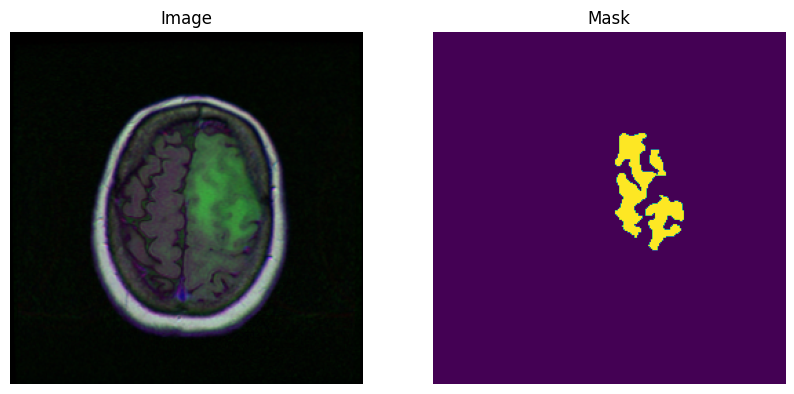

(256, 256, 3) (256, 256)


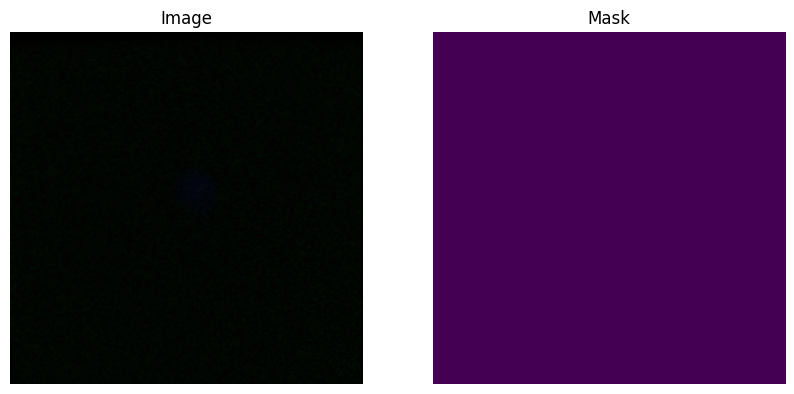

(256, 256, 3) (256, 256)


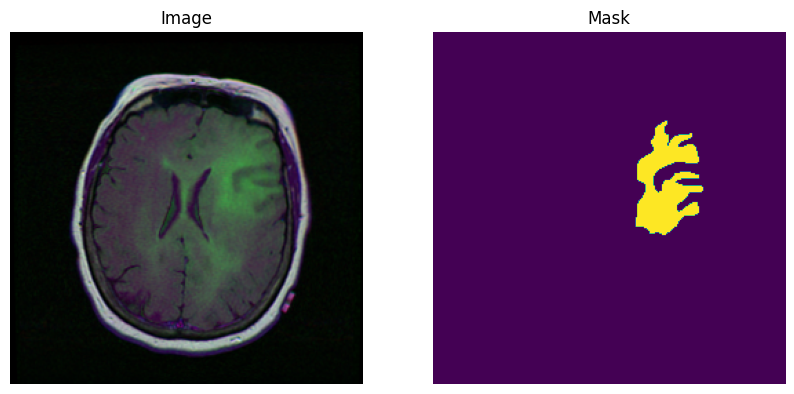

(256, 256, 3) (256, 256)


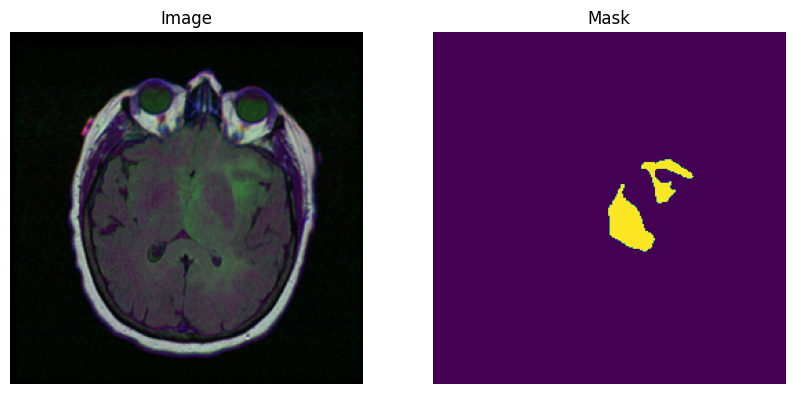

(256, 256, 3) (256, 256)


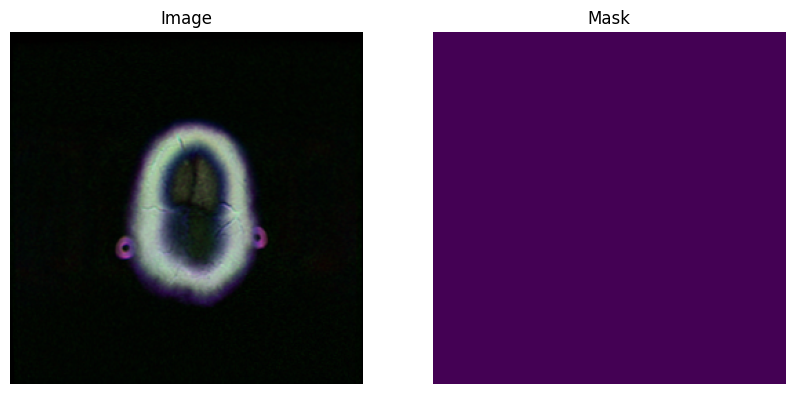

In [9]:
show_mri(df_mri)

After looking at several MRI we can see that some of them miss important information (several do not have the FLAIR channel, or a cut one). </br>
Therefore we will use all 3 channels instead of just the second one (FLAIR).

In [10]:
SIZE_W=256
SIZE_H=256

# Quick study

In [11]:
def open_img(image_path, mask=False, SIZE_W=SIZE_W, SIZE_H=SIZE_H):

    image = cv2.imread(image_path)
    image = cv2.resize(image,  dsize=(SIZE_W, SIZE_H), interpolation=cv2.INTER_NEAREST)
    
    
    #image = np.asarray(image,dtype = np.float64)
    if mask:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) 
        image = np.expand_dims(image, axis=-1)
    else:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
    return image.astype(np.float32)

def normalize(image):

    image = image / 255.0    
    return image

def pipeline(image_path, mask=False):
    image  = open_img(image_path, mask)
    image = normalize(image)

    return image

In [12]:
dataset_img  = np.array([pipeline(mri_path) for mri_path in list(dic_mri.keys())])
#dataset_img  = np.expand_dims(dataset_img, axis=-1)
dataset_mask = np.array([pipeline(mask_path, mask=True) for mask_path in list(dic_mri.values())])

A quick statistical study of our masks:

We create a dataframe with the number of pixels for each tumor and the percentage of mask it takes.

In [13]:
percentage_tumor = pd.DataFrame({'pixel_tumor':[np.sum(mask) for mask in dataset_mask], 'percentage_tumor':[np.sum(mask)/(SIZE_W*SIZE_H) for mask in dataset_mask]})
percentage_tumor.describe()

,pixel_tumor,percentage_tumor
count,3929.000000,3929.000000
mean,674.943726,0.010299
std,1290.544312,0.019692
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,821.000000,0.012527
max,7929.000000,0.120987


More than half of the slices have no tumors, and the biggest tumor takes 12% of the mask.

How many MRI have a tumor?

In [14]:
percentage_tumor['tumor?'] = (percentage_tumor['pixel_tumor'] > 0)

We have a lot more slices without a tumor than with one.

<Axes: xlabel='tumor?', ylabel='count'>

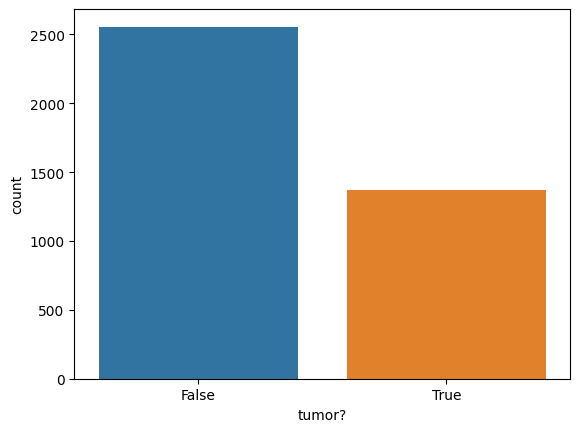

In [15]:
sns.countplot(percentage_tumor, x="tumor?")

In [16]:
percentage_tumor['tumor?'].value_counts()

tumor?
False    2556
True     1373
Name: count, dtype: int64

This is a very important information, it means that we will need to be very careful with our error and accuracy functions. </br>
Indeed, by only outputing black pixels our model will already show a 90% accuracy and a very low loss. Maybe it would be better to use a different loss and accuracy metric to have more readable results?

In [17]:
percentage_tumor['percentage_tumor'].sum()/len(percentage_tumor['percentage_tumor'])

0.010298824334575433

# Data pipeline

As said before, the images are in .tif format. This format is not well implemented in TF and I wasn't able to make the tif experimental functions work in this notebook. I therefore prefered to open the tif images with OpenCV, preprocess them with it, add them all to a list, and built a TF dataset using tf.data.Dataset.from_tensor_slices. It is clearly not the best way to do things but it was the best for me at the time.

In [18]:
def process_path(image_path, mask_path, img_width=SIZE_W, img_height=SIZE_H):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width, img_height), interpolation = cv2.INTER_NEAREST)
    image = image.astype(np.float32)
    image = image / 255.0
        
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY) # goes from dim=3 to dim=2
    mask = cv2.resize(mask, (img_width, img_height), interpolation = cv2.INTER_NEAREST)
    mask = mask.astype(np.float32)
    mask = mask / 255.0

    return image, mask[:,:,None] # None adds back the lost dim 



In [19]:
images_process = []
masks_process = []

for image_path, mask_path in zip(list(dic_mri.keys()), list(dic_mri.values())):
    image_process, mask_process = process_path(image_path,mask_path)
    images_process += [image_process]
    masks_process += [mask_process]

As it is only a simple demonstration of a Unet I didn't use a test dataset but only a train and valid one.

In [20]:
from sklearn.model_selection import train_test_split

train_images, valid_images, train_masks, valid_masks = train_test_split(images_process , masks_process, test_size=0.2, random_state=1)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_masks))

# Unet model

In [22]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = tf.keras.layers.Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = tf.keras.layers.Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
         
        
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [23]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = tf.keras.layers.Conv2DTranspose(
                 n_filters,   
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)
    conv = tf.keras.layers.Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = tf.keras.layers.Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [24]:
def Unet_model(input_size=(256, 256, 3), n_filters=64, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = tf.keras.layers.Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, 0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, 0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(n_classes, (1,1), padding='same', activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

We could use accuracy as metric and a simple binarycrossentropy as loss function (or sparse categoricalcross entropy using 2 classes) but as I said before it's not very readable with this dataset. </br>
Why not try something else with the Dice loss and the IoU (Intersection over Union) metric? </br>
First the **Dice loss**: </br>
* You compute the intersection of the true mask and predicted mask.

It's like superposing the masks and only keeping the parts that are shared by both.
* You add the predicted and true mask.
* You divide 2 times the intersection by the sum previously computed.

If the mask is perfectly predicted you should obtain 1 (the sum would be exactly two time the mask, and also the intersection multiplied by 2). </br>
Note the "smooth" value added to the denominator and dice loss. It has mainly two jobs:
* Avoid dividing by zero when there is no mask predicted and to be predicted.
* Avoir to obtain 0 when the intersection is 0 (no mask predicted, no mask to predict, or simply no intersection between the two.)

The second point is important when there is no mask to predict. Without the smooth value the dice loss will be 0 (the highest loss value) even if the model doesn't predict any mask (an accuracy of 100% if no mask needed to be predicted). </br>
Then we substract 1 by the dice loss to make it more readable. The highest value (worse) will be 1 and the smallest (best) 0 (the loss needs to be minized by the model).

Second, the **IoU**:
* We again compute the intersection
* And we also compute the Union 

The union is the sum of the predicted and true mask minus there intersection. </br>
Again we add a smooth value to avoid to divide by 0 or to compute the case without mask as failures. </br>
For the IoU, the best value is 1 and the worst is 0.

In [25]:
def dice_loss(y_true, y_pred, smooth = 0.1):
    y_true=tf.keras.backend.flatten(y_true)
    y_pred=tf.keras.backend.flatten(y_pred)
    intersec=tf.keras.backend.sum(y_true* y_pred)
    denominator = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth
    dice_loss = ((2 * intersec) + smooth) / denominator
    return 1 - dice_loss

def iou(y_true,y_pred, smooth = 0.1):
    intersec = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true + y_pred) - intersec
    iou = (intersec + smooth) / (union + smooth)
    return iou

In [26]:
unet = Unet_model((SIZE_W,SIZE_H,3))

In [27]:
unet.compile(optimizer=Adam(learning_rate=1e-5),
              loss=dice_loss,
              metrics=[iou])

In [28]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

I put the batch size to 16 because of memory requirement. You can try to increase it to 32 if you can/want.

In [29]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 16
train_ds = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_ds = valid_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))


In [30]:
history = unet.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/40


2024-02-08 09:34:40.449309: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707384899.404939      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - 314s 1s/step - loss: 0.8661 - iou: 0.0801 - val_loss: 0.8959 - val_iou: 0.0577
Epoch 2/40
197/197 [==============================] - 223s 1s/step - loss: 0.5203 - iou: 0.3333 - val_loss: 0.6383 - val_iou: 0.2392
Epoch 3/40
197/197 [==============================] - 222s 1s/step - loss: 0.3990 - iou: 0.4464 - val_loss: 0.4158 - val_iou: 0.4283
Epoch 4/40
197/197 [==============================] - 222s 1s/step - loss: 0.3705 - iou: 0.4770 - val_loss: 0.4724 - val_iou: 0.3661
Epoch 5/40
197/197 [==============================] - 222s 1s/step - loss: 0.3453 - iou: 0.5026 - val_loss: 0.4393 - val_iou: 0.3938
Epoch 6/40
197/197 [==============================] - 223s 1s/step - loss: 0.3267 - iou: 0.5217 - val_loss: 0.6076 - val_iou: 0.2502
Epoch 7/40
197/197 [==============================] - 222s 1s/step - loss: 0.2965 - iou: 0.5544 - val_loss: 0.3759 - val_iou: 0.4600
Epoch 8/40
197/197 [==============================] - 222s 1s/step - loss: 0.300

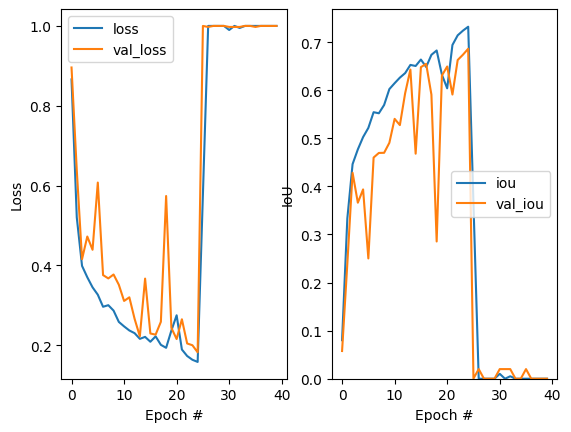

In [31]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['iou'], label='iou')
plt.plot(history.history['val_iou'], label='val_iou')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('IoU')
plt.legend()

# The results

In [32]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [33]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [34]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = (unet.predict(image) > 0.5)*1.0
            display([image[0], mask[0], pred_mask[0]])

1/1 [==============================] - 0s 312ms/step


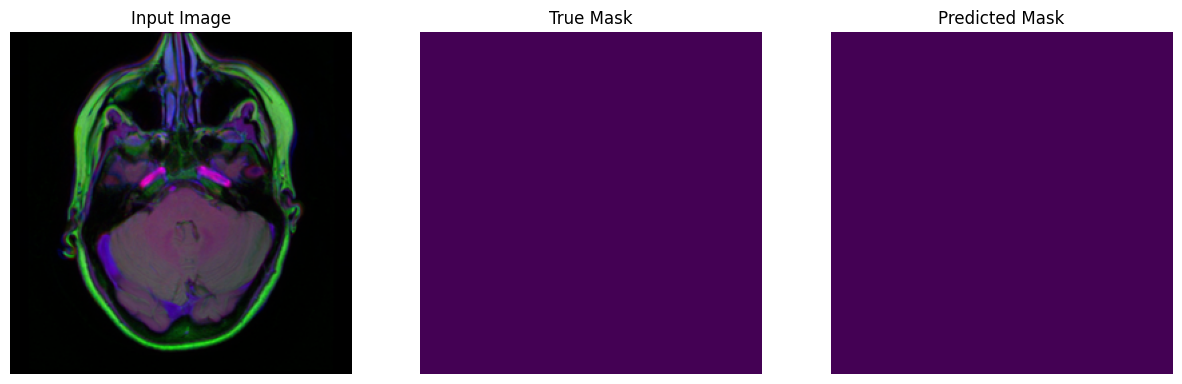

1/1 [==============================] - 0s 26ms/step


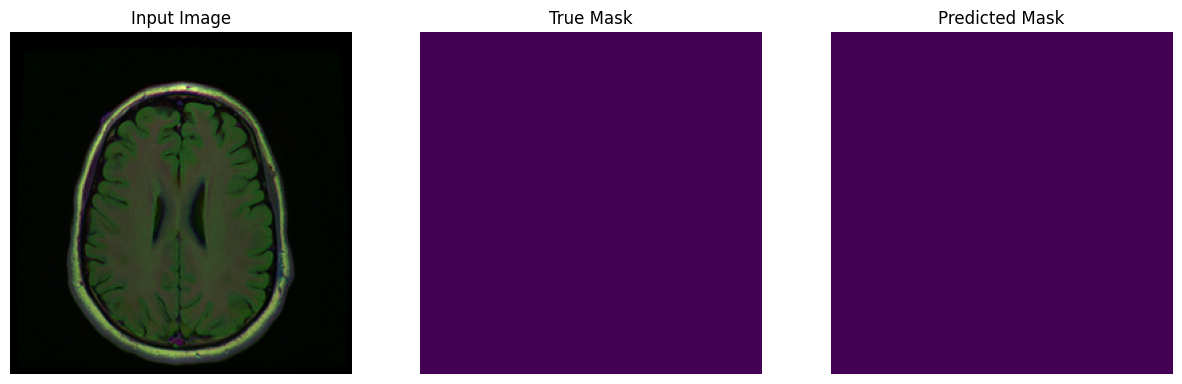

1/1 [==============================] - 0s 28ms/step


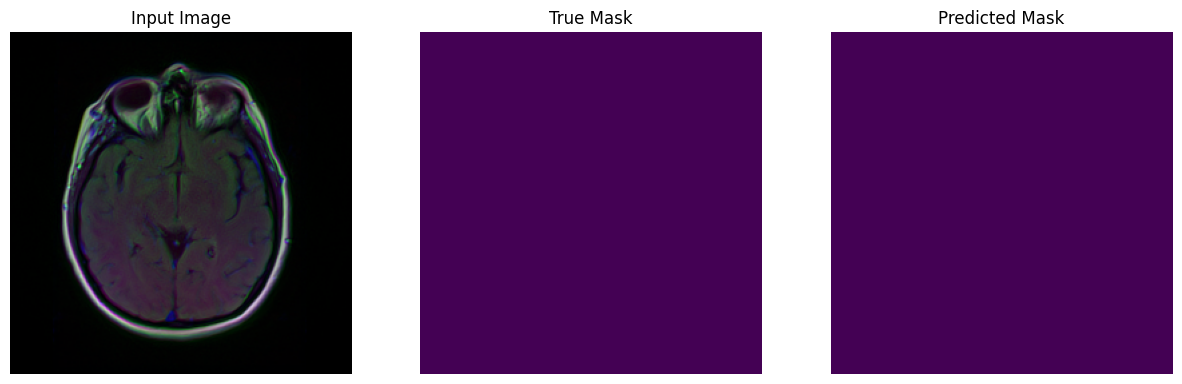

1/1 [==============================] - 0s 32ms/step


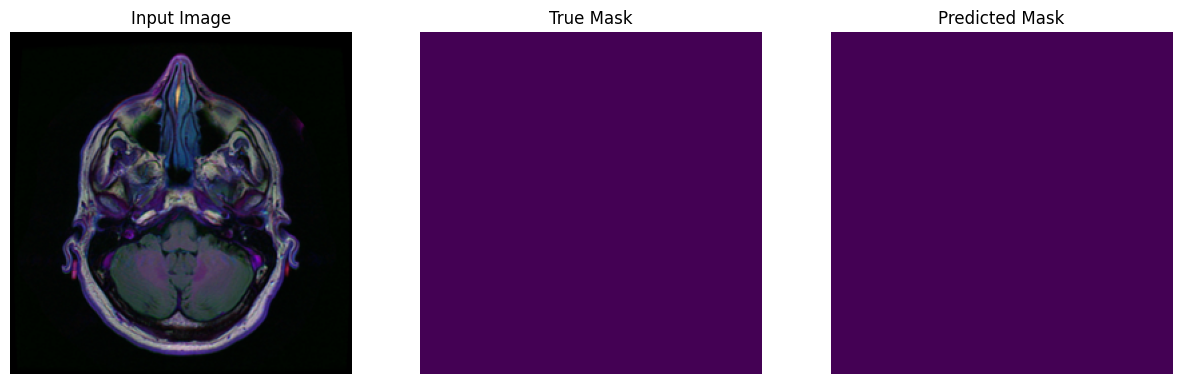

1/1 [==============================] - 0s 26ms/step


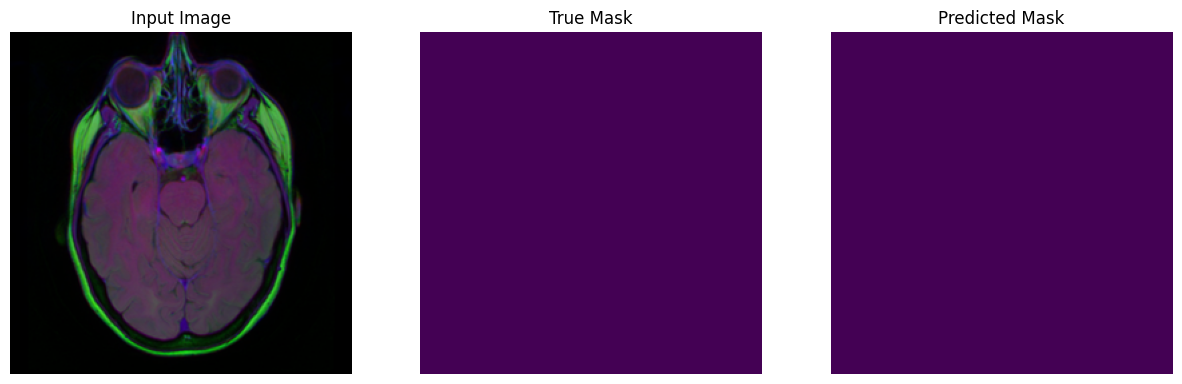

1/1 [==============================] - 0s 26ms/step


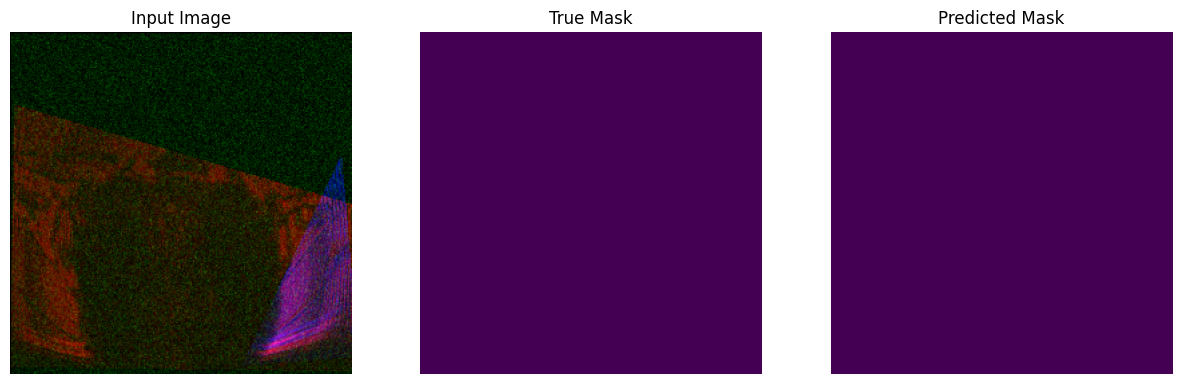

In [35]:
show_predictions(valid_ds, 6)